- Calculate Theil-Sen slope maps for the HYPFLOWSCI6 dataset (PCR-Globwb run) https://doi.org/10.24416/UU01-YM7A5H 
- For total GW storage and for TWS trends to compare with Grace TWS trend (harmonic solution)
- with preprocessing: moving window average, coarsened, ocean and temperture mask

In [8]:
%reset -f
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import theilslopes
import scipy.ndimage
from cartopy.feature import NaturalEarthFeature
import cartopy.crs as ccrs
from matplotlib.colors import Normalize

%matplotlib inline

In [9]:
# Importdata
TWS_GLOBWB = xr.open_dataset('/eejit/depfg/sutan101/pcrglobwb_wri_aqueduct_2021/pcrglobwb_aqueduct_2021_monthly_annual_files/version_2021-09-16/gswp3-w5e5/historical-reference/begin_from_1960/global/netcdf_monthly_1979-2019/totalWaterStorageThickness_monthAvg_output_1979-2019.nc')
GW_GLOBWB = xr.open_dataset('/eejit/depfg/sutan101/pcrglobwb_wri_aqueduct_2021/pcrglobwb_aqueduct_2021_monthly_annual_files/version_2021-09-16_merged/gswp3-w5e5/historical-reference/pcrglobwb_cmip6-isimip3-gswp3-w5e5_image-aqueduct_historical-reference_storGroundwater_global_monthly-average_1960_2019_basetier1.nc')
GW_GLOBWB_fossil = xr.open_dataset('/eejit/depfg/sutan101/pcrglobwb_wri_aqueduct_2021/pcrglobwb_aqueduct_2021_monthly_annual_files/version_2021-09-16_merged/gswp3-w5e5/historical-reference/pcrglobwb_cmip6-isimip3-gswp3-w5e5_image-aqueduct_historical-reference_storGroundwaterFossil_global_monthly-average_1960_2019_basetier1.nc')
temp_annual = xr.open_dataset('/eejit/depfg/sutan101/pcrglobwb_wri_aqueduct_2021/pcrglobwb_aqueduct_2021_monthly_annual_files/version_2021-09-16_merged/gswp3-w5e5/historical-reference/pcrglobwb_cmip6-isimip3-gswp3-w5e5_image-aqueduct_historical-reference_temperature_global_yearly-average_1960_2019_basetier1.nc')
ocean_mask = xr.open_dataset('/home/bauer013/ls/data/IMERG_land_sea_mask.nc')

In [10]:
#ocean mask fata from https://gpm.nasa.gov/data/directory/imerg-land-sea-mask-netcdf 23.04.2024
ocean_mask = ocean_mask.sel(lon=slice(0, 360))
ocean_mask = ocean_mask.sel(lon=(ocean_mask['lon'] < 60) | (ocean_mask['lon'] > 349))
ocean_mask = ocean_mask.sel(lat=(ocean_mask['lat'] > 35) & (ocean_mask['lat'] < 72 ))
ocean_mask = ocean_mask.coarsen(lon=10, lat=10).mean()
ocean_mask['lon'] = (ocean_mask['lon'] + 180) % 360 - 180
ocean_mask['lon'] = np.concatenate([ocean_mask['lon'].values[60:], ocean_mask['lon'].values[:60]])
slope_reordered = np.concatenate([ocean_mask['landseamask'].values[:, 60:], ocean_mask['landseamask'].values[:, :60]], axis=1)
ocean_mask['landseamask'] = xr.DataArray(slope_reordered, dims=('lat', 'lon'), coords={'lat': ocean_mask['lat'], 'lon': ocean_mask['lon']})
ocean_mask  = ocean_mask.expand_dims({'time': temp_annual.time}, axis=0)
ocean_mask = ocean_mask.groupby('time.year').mean(dim='time')
ocean_mask = ocean_mask.sel(year=slice(2002, None))
# adjust parameter. Which percentage needs to be water
ocean_mask = ocean_mask['landseamask'] > 75 # Typical percentage thresholds used to define sea are 100% (strictly open water) or 75% (including sea-ward coast areas)
ocean_mask['lat'] = np.round(ocean_mask['lat'], decimals=2)
ocean_mask['lon'] = np.round(ocean_mask['lon'], decimals=2)
ocean_mask = ocean_mask.sortby('lat', ascending=False)

In [11]:
#Temperture Mask
temp_annual = temp_annual.sel(lon=(temp_annual['lon'] < 60) & (temp_annual['lon'] > -11)) 
temp_annual = temp_annual.sel(lat=(temp_annual['lat'] > 35) & (temp_annual['lat'] < 72))
#adjust if mean cell temperture or min cell temperture should be calculated
temp_mean = temp_annual.mean(dim='time', keep_attrs=True)
temp_mean  = temp_mean.expand_dims({'time': temp_annual.time}, axis=0)
temp_mean = temp_mean.groupby('time.year').mean(dim='time')
temp_mean = temp_mean.sel(year=slice(2002, None))
temp_mask = temp_mean['temperature'] < 0 
temp_mask['lat'] = np.round(temp_mask['lat'], decimals=2)
temp_mask['lon'] = np.round(temp_mask['lon'], decimals=2)

In [12]:
#preprocessing GW
GW_GLOBWB = GW_GLOBWB.sel(lon=(GW_GLOBWB['lon'] < 60) & (GW_GLOBWB['lon'] > -11)) 
GW_GLOBWB = GW_GLOBWB.sel(lat=(GW_GLOBWB['lat'] > 35) & (GW_GLOBWB['lat'] < 72))
GW_GLOBWB = GW_GLOBWB.groupby('time.year').mean(dim='time')
GW_GLOBWB = GW_GLOBWB.sel(year=slice(2002, None))
GW_GLOBWB['lat'] = np.round(GW_GLOBWB['lat'], decimals=2)
GW_GLOBWB['lon'] = np.round(GW_GLOBWB['lon'], decimals=2)
GW_GLOBWB['groundwater_storage'] = GW_GLOBWB['groundwater_storage'].where(~temp_mask, np.nan) # Applying temperature mask
GW_GLOBWB = GW_GLOBWB.coarsen(lon=12, lat=12).mean()
GW_GLOBWB['lat'] = np.round(GW_GLOBWB['lat'], decimals=1)
GW_GLOBWB['lon'] = np.round(GW_GLOBWB['lon'], decimals=1)
GW_GLOBWB['groundwater_storage'] = GW_GLOBWB['groundwater_storage'].where(~ocean_mask, np.nan)  # Applying ocean mask

#GW Fossil
GW_GLOBWB_fossil = GW_GLOBWB_fossil.sel(lon=(GW_GLOBWB_fossil['lon'] < 60) & (GW_GLOBWB_fossil['lon'] > -11)) 
GW_GLOBWB_fossil = GW_GLOBWB_fossil.sel(lat=(GW_GLOBWB_fossil['lat'] > 35) & (GW_GLOBWB_fossil['lat'] < 72))
GW_GLOBWB_fossil = GW_GLOBWB_fossil.groupby('time.year').mean(dim='time')
GW_GLOBWB_fossil = GW_GLOBWB_fossil.sel(year=slice(2002, None))
GW_GLOBWB_fossil['lat'] = np.round(GW_GLOBWB_fossil['lat'], decimals=2)
GW_GLOBWB_fossil['lon'] = np.round(GW_GLOBWB_fossil['lon'], decimals=2)
GW_GLOBWB_fossil['fossil_groundwater_storage'] = GW_GLOBWB_fossil['fossil_groundwater_storage'].where(~temp_mask, np.nan) # Applying temperature mask
GW_GLOBWB_fossil = GW_GLOBWB_fossil.coarsen(lon=12, lat=12).mean()
GW_GLOBWB_fossil['lat'] = np.round(GW_GLOBWB_fossil['lat'], decimals=1)
GW_GLOBWB_fossil['lon'] = np.round(GW_GLOBWB_fossil['lon'], decimals=1)
GW_GLOBWB_fossil['fossil_groundwater_storage'] = GW_GLOBWB_fossil['fossil_groundwater_storage'].where(~ocean_mask, np.nan) # Applying ocean mask

GW_GLOBWB['groundwater_storage'] = GW_GLOBWB_fossil['fossil_groundwater_storage'] + GW_GLOBWB['groundwater_storage']
lon_range = GW_GLOBWB['lon'].values 
lat_range = GW_GLOBWB['lat'].values 

#apply a moving window average GW

GW_GLOBWB = GW_GLOBWB.rolling(lon=5, lat=5, center=True, min_periods=15).mean()
#apply again ocean mask
GW_GLOBWB['groundwater_storage'] = GW_GLOBWB['groundwater_storage'].where(~ocean_mask, np.nan)

In [7]:
# TWS_prcglob Preprocessing
TWS_GLOBWB = TWS_GLOBWB.sel(longitude=(TWS_GLOBWB['longitude'] < 60) & (TWS_GLOBWB['longitude'] > -11))
TWS_GLOBWB = TWS_GLOBWB.sel(latitude=(TWS_GLOBWB['latitude'] > 35) & (TWS_GLOBWB['latitude'] < 72))
#ADJUST TO GRACE GRID
TWS_GLOBWB = TWS_GLOBWB.rename({'latitude': 'lat'})
TWS_GLOBWB = TWS_GLOBWB.rename({'longitude': 'lon'})
TWS_GLOBWB['lat'] = np.round(TWS_GLOBWB['lat'], decimals=2)
TWS_GLOBWB['lon'] = np.round(TWS_GLOBWB['lon'], decimals=2)
TWS_GLOBWB = TWS_GLOBWB.groupby('time.year').mean(dim='time')
TWS_GLOBWB = TWS_GLOBWB.sel(year=slice(2002, None))
#applying temperutre mask 
TWS_GLOBWB['total_thickness_of_water_storage'] = TWS_GLOBWB['total_thickness_of_water_storage'].where(~temp_mask, np.nan)
TWS_GLOBWB = TWS_GLOBWB.coarsen(lon=12, lat=12).mean()
TWS_GLOBWB['lat'] = np.round(TWS_GLOBWB['lat'], decimals=2)
TWS_GLOBWB['lon'] = np.round(TWS_GLOBWB['lon'], decimals=2)
#applyingbmask ocean
TWS_GLOBWB['total_thickness_of_water_storage'] = TWS_GLOBWB['total_thickness_of_water_storage'].where(~ocean_mask, np.nan)

lon_range = TWS_GLOBWB['lon'].values #longitude
lat_range = TWS_GLOBWB['lat'].values #latitude

window_size = 5
TWS_GLOBWB = TWS_GLOBWB.rolling(lon=window_size, lat=window_size, center=True, min_periods=15).mean()
#apply again ocean mask
TWS_GLOBWB['total_thickness_of_water_storage'] = TWS_GLOBWB['total_thickness_of_water_storage'].where(~ocean_mask, np.nan)

In [13]:
#create new dataset to store values
TS_slope = xr.Dataset(
    {'slope': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
     'intercept': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
     'low_slope': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
     'high_slope': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range))))},
    coords={'lat': lat_range, 'lon': lon_range},
)


In [14]:
#calculate slope

for lon in lon_range:
  for lat in lat_range:
    #iwe = TWS_GLOBWB['total_thickness_of_water_storage'].sel(lon=lon, lat=lat, method='nearest') # for TWS
    iwe = GW_GLOBWB['groundwater_storage'].sel(lon=lon, lat=lat, method='nearest') # totGW
    slope_top, intercept_top, low_slope_top, high_slope_top =  theilslopes(iwe.values, iwe['year'].values, alpha=0.95, method='separate')
    TS_slope['slope'].loc[{'lat': lat, 'lon': lon}] = slope_top
    TS_slope['intercept'].loc[{'lat': lat, 'lon': lon}] = intercept_top
    TS_slope['low_slope'].loc[{'lat': lat, 'lon': lon}] = low_slope_top
    TS_slope['high_slope'].loc[{'lat': lat, 'lon': lon}] = high_slope_top
    


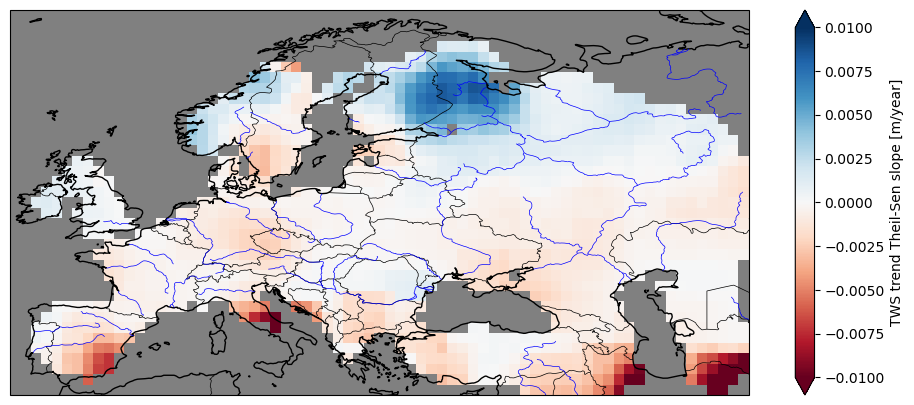

In [15]:
#PLot TS slope
fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = plt.get_cmap('RdBu_r')
cmap = cmap.reversed()

# Set the range for colors
vmin, vmax = -0.01, 0.01

# Plot the slope 
c = ax.pcolormesh(TS_slope['lon'].values, TS_slope['lat'].values, TS_slope['slope'].values, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), shading='auto')
cmap.set_bad(color='grey', alpha=1.0) 

# Add coastlines for reference
ax.coastlines()
countries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', edgecolor='black', facecolor='none')
rivers = NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', scale='50m', edgecolor='blue', facecolor='none')
ax.add_feature(countries, linestyle='-', linewidth=0.5)
ax.add_feature(rivers, linestyle='-', linewidth=0.5)

# Add colorbar
plt.colorbar(c, ax=ax, label='TWS trend Theil-Sen slope [m/year]',  extend='both', orientation='vertical')
# Show the plot
plt.show()
